In [1]:
import torch
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'
batch_size = 64

train_set = MNIST(download_root, transform=transform, train=True, download=True)
test_set = MNIST(download_root, transform=transform, train=False, download=True)

train_dataset = torch.utils.data.DataLoader(MNIST(download_root, transform=transform, train=True, download=True), batch_size=batch_size, shuffle=True, drop_last=True)
test_dataset = torch.utils.data.DataLoader(MNIST(download_root, transform=transform, train=False, download=True), batch_size=len(test_set), shuffle=True, drop_last=True)

10000


/usr/local/var/pyenv/versions/3.7.10/envs/NLP/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# 하나의 이미지 예시
images, labels = next(iter(train_dataset))

In [3]:
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
torch_image = images[0]
print(torch_image.shape)
torch_image = torch.squeeze(torch_image)
print(torch_image.shape)

label = labels[0].numpy()
print(label)

torch.Size([1, 28, 28])
torch.Size([28, 28])
7


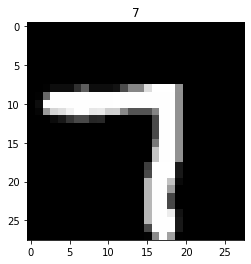

In [6]:
plt.title(label)
plt.imshow(torch_image, 'gray')
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layer(x)

In [9]:
from sklearn.preprocessing import label_binarize

def drawROCandAUCscore(pred, target):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 10
    classes = [i for i in range(n_classes)]
    pred = label_binarize(pred, classes=classes)
    target = label_binarize(target, classes=classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(pred[:, i], target[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(20, 10))
    for idx, i in enumerate(range(n_classes)):
        plt.subplot(2,5,i+1)
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate', rotation=0)
        plt.title('Class %0.0f' % idx)
        plt.legend(loc="lower right")
    plt.show()

    print("roc_auc_score: ", roc_auc_score(pred, target, multi_class='ovo'))

In [10]:
model = Model().to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.cross_entropy
# 텐서보드로 그리기
writer = SummaryWriter()

In [12]:
def train(model, train_dataset, optimizer):
    model.train()
    loss_val = 0
    for data, target in train_dataset:
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)
        pred = model(data)
        optimizer.zero_grad()
        loss = loss_fn(pred, target)
        loss_val = loss.item()
        loss.backward()
        optimizer.step()
    print("Train Epoch: {} ".format(epoch))

def evaluate(model, test_dataset):
    model.eval()
    test_loss = 0
    correct = 0
    cf_matrix = np.zeros((10, 10), dtype=np.int)
    labels = [i for i in range(10)]
    with torch.no_grad(): # 평가 과정에서는 기울기를 계산하지 않으므로, no_grad명시
        for data, target in test_dataset:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.argmax(1)
# 일반 반복문을 통해 confusion matrix 생성            
#             for i in range(batch_size):
#                 confusion_matrix[pred[i]][target[i]] += 1

            cf_matrix += confusion_matrix(pred, target, labels=labels)
            
            # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataset.dataset)
    test_accuracy = 100. * correct / len(test_dataset.dataset)
    
# 평가 지표들 계산(Confusion matrix, recall, precision, accuracy, loss, f1 score, roc, auc)
    print("Confusion Matrix: ", cf_matrix)
    recall_all = recall_score(pred, target, average=None)
    recall_avg = recall_score(pred, target, average='weighted')
    print("recall all:", recall_all)
    print("recall avg:", recall_avg)
    precision_all = precision_score(pred, target, average=None)
    precision_avg = precision_score(pred, target, average='weighted')
    print("precision all:", precision_all)
    print("precision avg:", precision_avg)
    f1_avg = f1_score(pred, target, average='weighted')
    print("f1 avg:", f1_avg)
    writer.add_scalar('test_accuracy', test_accuracy, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_recall(avg)', recall_avg, epoch)
    writer.add_scalar('test_precision(avg)', precision_avg, epoch)
    writer.add_scalar('test_f1(avg)', f1_avg, epoch)
    drawROCandAUCscore(pred, target)
    return test_loss, test_accuracy

MNIST Training...:   0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch: 1 
Pred: tensor([3, 3, 1,  ..., 4, 4, 2])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 969    0    4    1    1    3    8    0    3    3]
 [   0 1122    2    0    0    0    3   12    2    6]
 [   0    4  995   10    2    0    0   14    3    0]
 [   3    1    8  984    0   12    0    8   19   12]
 [   1    0    6    0  960    0    9    3    5   16]
 [   2    1    0    4    0  857    9    1    4    4]
 [   3    4    2    0    5    9  925    0    4    1]
 [   1    0    9    3    1    0    0  973    5    6]
 [   1    3    6    7    2    7    4    1  926    2]
 [   0    0    0    1   11    4    0   16    3  959]]
recall all: [0.97681452 0.97820401 0.96789883 0.93982808 0.96       0.97165533
 0.9706191  0.9749499  0.96558916 0.96478873]
recall avg: 0.967
precision all: [0.98877551 0.98854626 0.96414729 0.97425743 0.97759674 0.96076233
 0.96555324 0.94649805 0.95071869 0.95044599]
precision avg: 0.9672167736926396
f1 avg: 0.9670256390719276


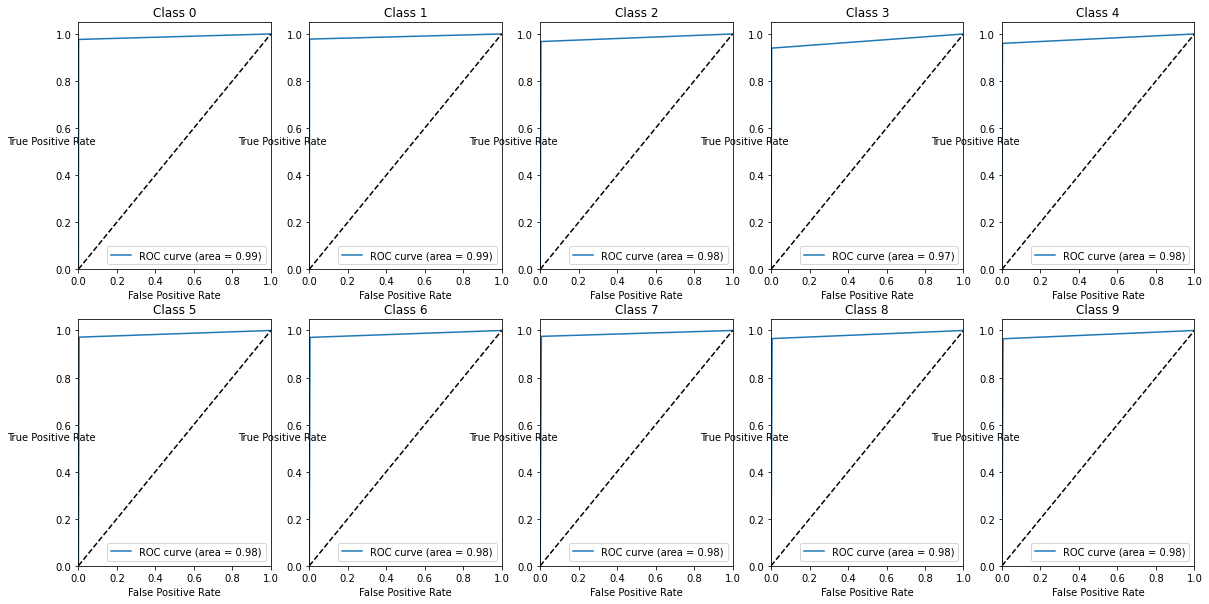

MNIST Training...:   7%|▋         | 1/15 [00:14<03:27, 14.83s/it]

roc_auc_score:  0.9816864356897698
[1] Test Loss: 0.1057, Accuracy: 96.70%
Train Epoch: 2 
Pred: tensor([7, 7, 6,  ..., 7, 6, 3])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 976    0   10    1    2    6   15    2   15    4]
 [   0 1120    1    0    0    0    3    7    0    3]
 [   0    3 1000    5    2    0    0    7    2    0]
 [   1    4    3  984    0    8    1    2   10    6]
 [   0    0    4    0  943    0    1    0    4   12]
 [   0    1    1    6    1  866    4    0   10    2]
 [   0    3    4    0    7    5  930    0    2    0]
 [   0    1    7    7    3    2    0 1002    5   10]
 [   1    3    2    2    1    2    4    2  920    2]
 [   2    0    0    5   23    3    0    6    6  970]]
recall all: [0.94665373 0.98765432 0.98135427 0.9656526  0.97821577 0.97194164
 0.97791798 0.96624879 0.97976571 0.95566502]
recall avg: 0.9711
precision all: [0.99591837 0.98678414 0.96899225 0.97425743 0.96028513 0.97085202
 0.97077244 0.97470817 0.94455852 0.96134787]
precision avg: 0

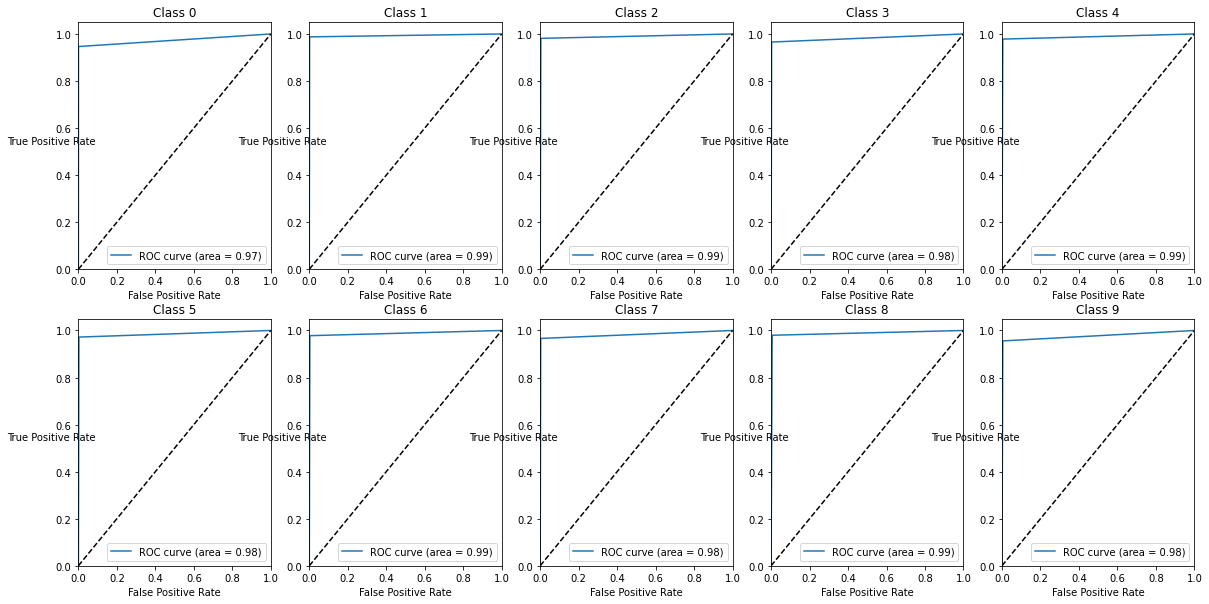

MNIST Training...:  13%|█▎        | 2/15 [00:29<03:13, 14.87s/it]

roc_auc_score:  0.983950414072868
[2] Test Loss: 0.0894, Accuracy: 97.11%
Train Epoch: 3 
Pred: tensor([6, 2, 8,  ..., 6, 5, 6])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 969    0    6    0    0    2    5    1    4    2]
 [   0 1121    2    0    0    0    3    5    0    2]
 [   0    1  988    3    8    0    0    6    1    0]
 [   1    2    7  981    0    8    1    0    1    0]
 [   0    0    3    0  965    1    3    0    5   14]
 [   3    1    0    6    0  869   13    0    4    1]
 [   2    1    1    0    1    3  927    0    0    1]
 [   0    1   10    7    2    1    0 1005    2    2]
 [   3    8   15    6    0    6    6    3  952    1]
 [   2    0    0    7    6    2    0    8    5  986]]
recall all: [0.97977755 0.98940865 0.98113208 0.98001998 0.97376387 0.96878484
 0.99038462 0.97572816 0.952      0.97047244]
recall avg: 0.9763
precision all: [0.98877551 0.9876652  0.95736434 0.97128713 0.98268839 0.97421525
 0.96764092 0.97762646 0.97741273 0.97720515]
precision avg: 0.

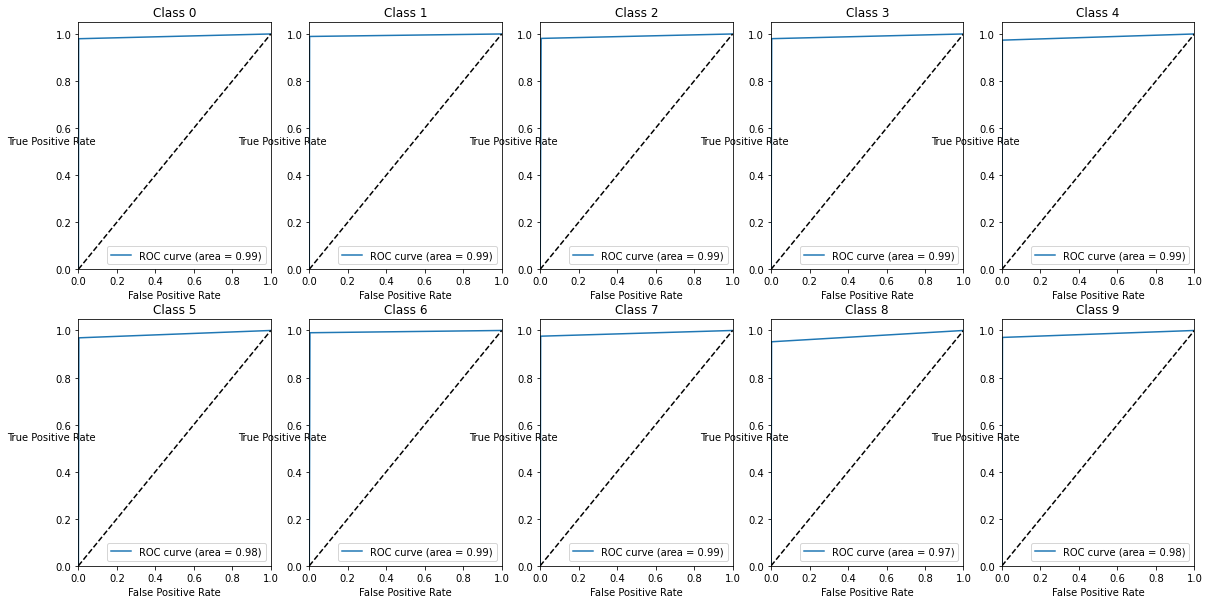

MNIST Training...:  20%|██        | 3/15 [00:44<02:58, 14.88s/it]

roc_auc_score:  0.9867577435674744
[3] Test Loss: 0.0760, Accuracy: 97.63%
Train Epoch: 4 
Pred: tensor([0, 8, 8,  ..., 2, 5, 3])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 971    0    2    0    0    2    4    2    1    2]
 [   1 1123    1    0    1    0    3    5    1    2]
 [   1    3 1012    6    7    0    1   11    2    0]
 [   0    0    2  984    0    9    1    2    1    4]
 [   0    0    2    0  956    2   10    0    0    7]
 [   2    0    0    4    0  858    2    0    1    5]
 [   1    2    0    0    1    8  932    0    0    0]
 [   0    1    3    2    1    0    0  996    2    2]
 [   2    6   10    7    0   12    5    3  964    4]
 [   2    0    0    7   16    1    0    9    2  983]]
recall all: [0.98678862 0.9876869  0.97027804 0.98105683 0.97850563 0.98394495
 0.98728814 0.98907646 0.95162883 0.96372549]
recall avg: 0.9779
precision all: [0.99081633 0.98942731 0.98062016 0.97425743 0.97352342 0.96188341
 0.97286013 0.9688716  0.98973306 0.97423191]
precision avg: 0

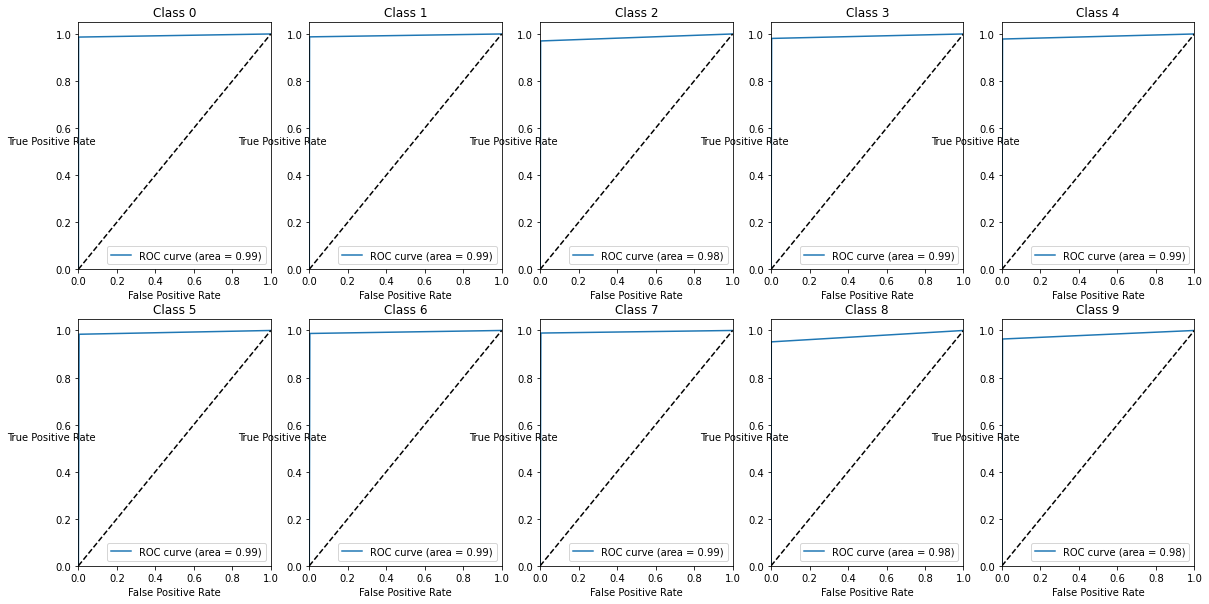

MNIST Training...:  27%|██▋       | 4/15 [00:59<02:43, 14.89s/it]

roc_auc_score:  0.9877730628942336
[4] Test Loss: 0.0690, Accuracy: 97.79%
Train Epoch: 5 
Pred: tensor([4, 4, 4,  ..., 5, 6, 5])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 964    0    1    0    0    2    1    1    2    2]
 [   1 1122    4    0    0    1    2    2    0    1]
 [   3    3 1007   10    6    0    1    9    2    0]
 [   1    0    3  963    0    3    0    1    3    2]
 [   0    0    3    0  950    2    4    1    3    6]
 [   0    1    0   18    0  876    7    0    8    3]
 [   7    4    0    0    1    5  940    0    0    1]
 [   1    1    3    5    3    1    0 1007    2    5]
 [   2    4   10    2    1    1    1    2  948    2]
 [   1    0    1   12   21    1    2    5    6  987]]
recall all: [0.99075026 0.99029126 0.9673391  0.98668033 0.98039216 0.95947426
 0.98121086 0.97957198 0.97430627 0.9527027 ]
recall avg: 0.9764
precision all: [0.98367347 0.98854626 0.97577519 0.95346535 0.96741344 0.98206278
 0.98121086 0.97957198 0.97330595 0.97819623]
precision avg: 0

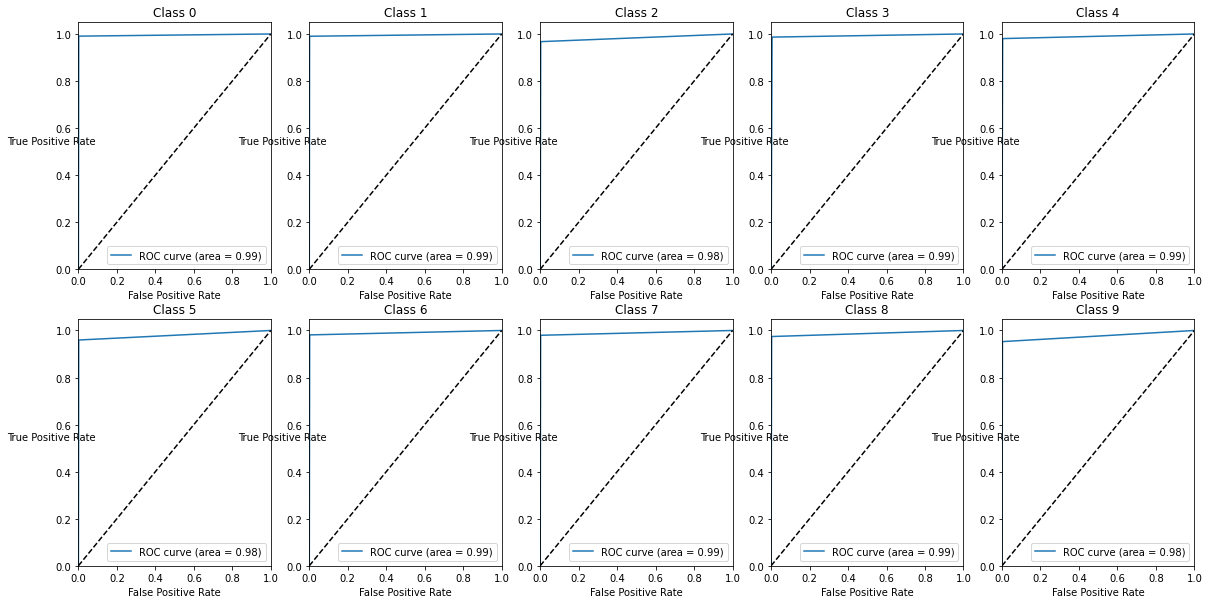

MNIST Training...:  33%|███▎      | 5/15 [01:14<02:29, 14.91s/it]

roc_auc_score:  0.9868255918559683
[5] Test Loss: 0.0749, Accuracy: 97.64%
Train Epoch: 6 
Pred: tensor([8, 1, 0,  ..., 9, 1, 0])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 971    2    0    0    1    2    5    1    5    3]
 [   0 1116    0    0    0    0    1    1    0    2]
 [   3    3 1008    3    1    0    0    6    2    0]
 [   0    2    6  990    0   11    1    0    2    4]
 [   0    0    1    0  967    0    4    2    2   10]
 [   0    0    0    4    0  867    5    0    3    4]
 [   1    2    1    0    4    1  934    0    0    0]
 [   1    1    7    7    2    1    0 1007    2    2]
 [   2    9    9    3    0    7    8    5  955    1]
 [   2    0    0    3    7    3    0    6    3  983]]
recall all: [0.98080808 0.99642857 0.98245614 0.97440945 0.98073022 0.98187995
 0.99045599 0.9776699  0.95595596 0.97616683]
recall avg: 0.9798
precision all: [0.99081633 0.98325991 0.97674419 0.98019802 0.98472505 0.97197309
 0.97494781 0.97957198 0.98049281 0.97423191]
precision avg: 0

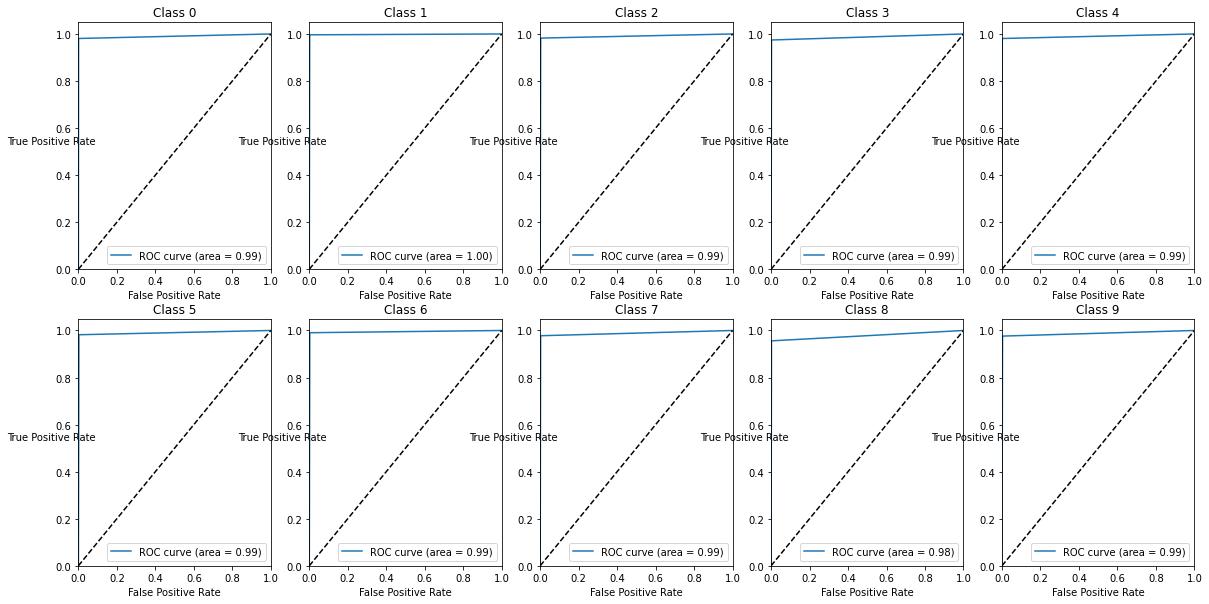

MNIST Training...:  40%|████      | 6/15 [01:29<02:14, 14.92s/it]

roc_auc_score:  0.9887261377981691
[6] Test Loss: 0.0705, Accuracy: 97.98%
Train Epoch: 7 
Pred: tensor([1, 5, 8,  ..., 9, 9, 7])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 972    0    2    0    1    0    9    2    0    2]
 [   1 1127    1    0    1    0    4    2    0    2]
 [   0    2 1016    5    2    0    1   10    1    0]
 [   2    1    1  992    1   13    1    2   14    4]
 [   0    0    1    0  969    0    6    0    2    7]
 [   1    0    0    4    1  874   11    0    2    4]
 [   1    0    1    0    0    1  921    0    0    0]
 [   0    1    5    3    1    0    0 1004    2    1]
 [   3    4    5    3    0    4    5    4  949    0]
 [   0    0    0    3    6    0    0    4    4  989]]
recall all: [0.98380567 0.99033392 0.97974928 0.96217265 0.98375635 0.97435897
 0.99675325 0.98721731 0.97134084 0.98310139]
recall avg: 0.9813
precision all: [0.99183673 0.99295154 0.98449612 0.98217822 0.98676171 0.97982063
 0.96137787 0.9766537  0.97433265 0.98017839]
precision avg: 0

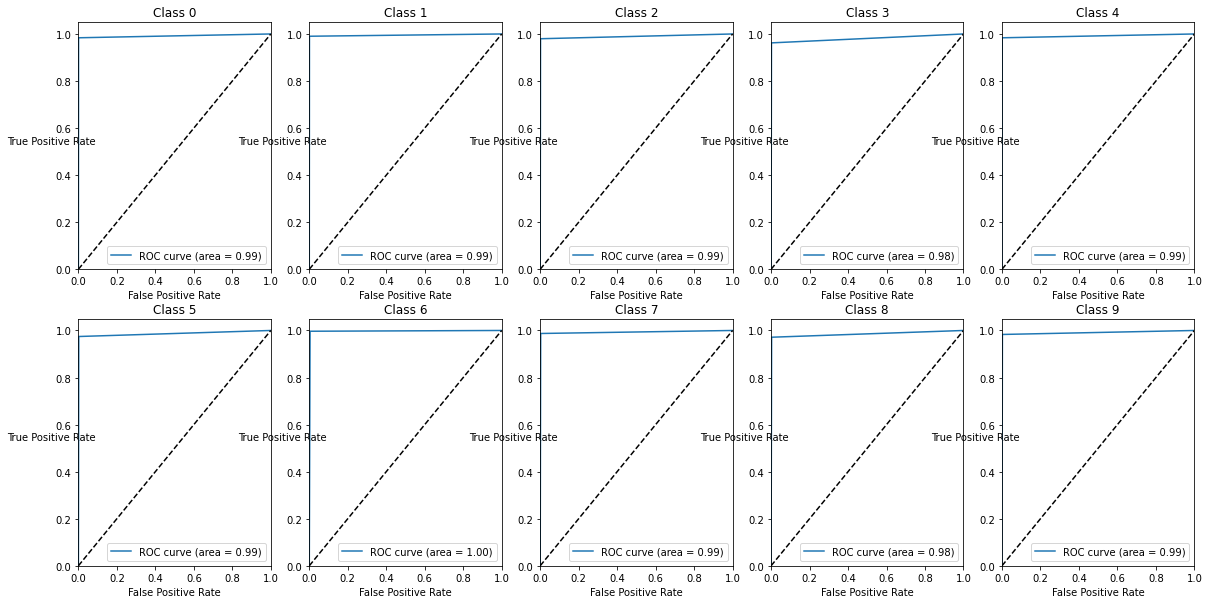

MNIST Training...:  47%|████▋     | 7/15 [01:44<01:59, 14.92s/it]

roc_auc_score:  0.9895922468809859
[7] Test Loss: 0.0723, Accuracy: 98.13%
Train Epoch: 8 
Pred: tensor([1, 7, 4,  ..., 0, 6, 6])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 971    0    2    0    1    3    2    1    7    3]
 [   1 1124    1    0    1    0    1    5    0    3]
 [   2    4 1005    1    3    0    0    5    3    0]
 [   1    1    7  998    0   18    1    3   13   11]
 [   0    0    1    0  965    0    2    0    2   10]
 [   0    0    0    3    2  866    9    0    5    7]
 [   3    3    1    0    4    3  941    0    0    1]
 [   1    0    8    4    1    0    0 1007    3    1]
 [   1    3    7    3    0    2    2    4  939    4]
 [   0    0    0    1    5    0    0    3    2  969]]
recall all: [0.98080808 0.98943662 0.98240469 0.94776828 0.98469388 0.97085202
 0.98430962 0.98243902 0.97305699 0.98877551]
recall avg: 0.9785
precision all: [0.99081633 0.99030837 0.97383721 0.98811881 0.98268839 0.97085202
 0.9822547  0.97957198 0.96406571 0.96035679]
precision avg: 0

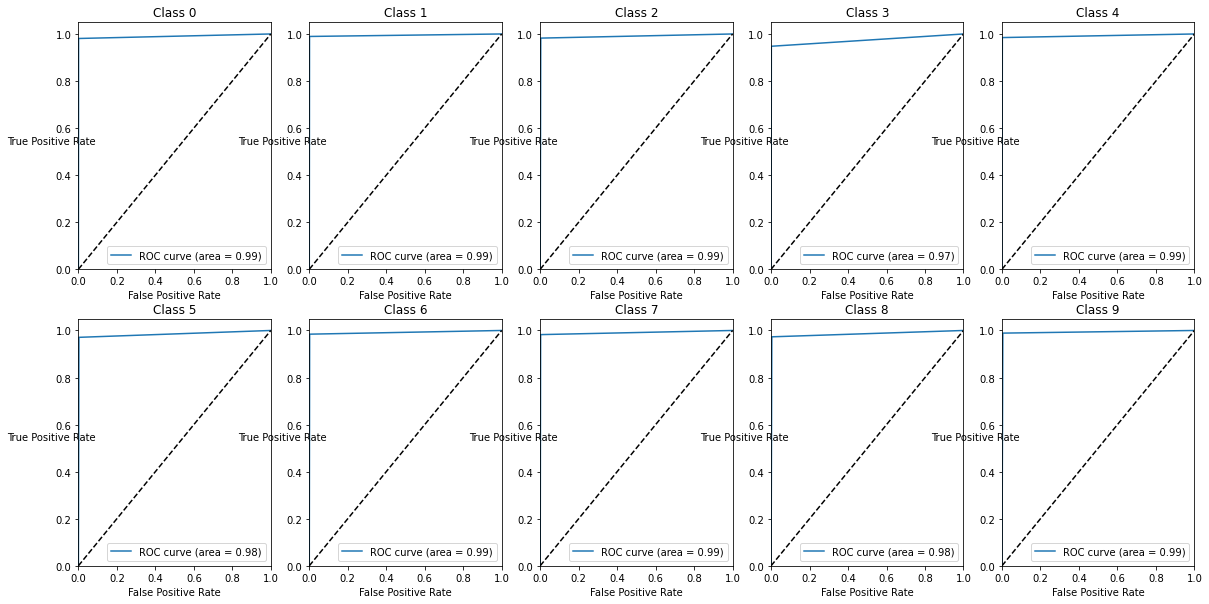

MNIST Training...:  53%|█████▎    | 8/15 [01:59<01:44, 14.91s/it]

roc_auc_score:  0.9880344329646888
[8] Test Loss: 0.0803, Accuracy: 97.85%
Train Epoch: 9 
Pred: tensor([2, 1, 5,  ..., 7, 9, 1])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 973    0    3    0    1    3   13    1    2    3]
 [   1 1128    0    0    1    0    3    2    2    2]
 [   1    4 1016    5    2    0    1    7    3    0]
 [   1    0    3  993    0   15    0    1   14    2]
 [   0    0    2    1  969    1    5    1    6   19]
 [   0    1    0    1    0  867   10    0    5    2]
 [   1    0    1    0    3    2  924    0    1    0]
 [   1    1    5    5    3    1    0 1008    5    8]
 [   2    1    1    2    0    1    2    2  929    1]
 [   0    0    1    3    3    2    0    6    7  972]]
recall all: [0.97397397 0.99034241 0.97786333 0.96501458 0.96513944 0.9785553
 0.99141631 0.97203472 0.98724761 0.9778672 ]
recall avg: 0.9779
precision all: [0.99285714 0.9938326  0.98449612 0.98316832 0.98676171 0.97197309
 0.96450939 0.98054475 0.95379877 0.96333003]
precision avg: 0.

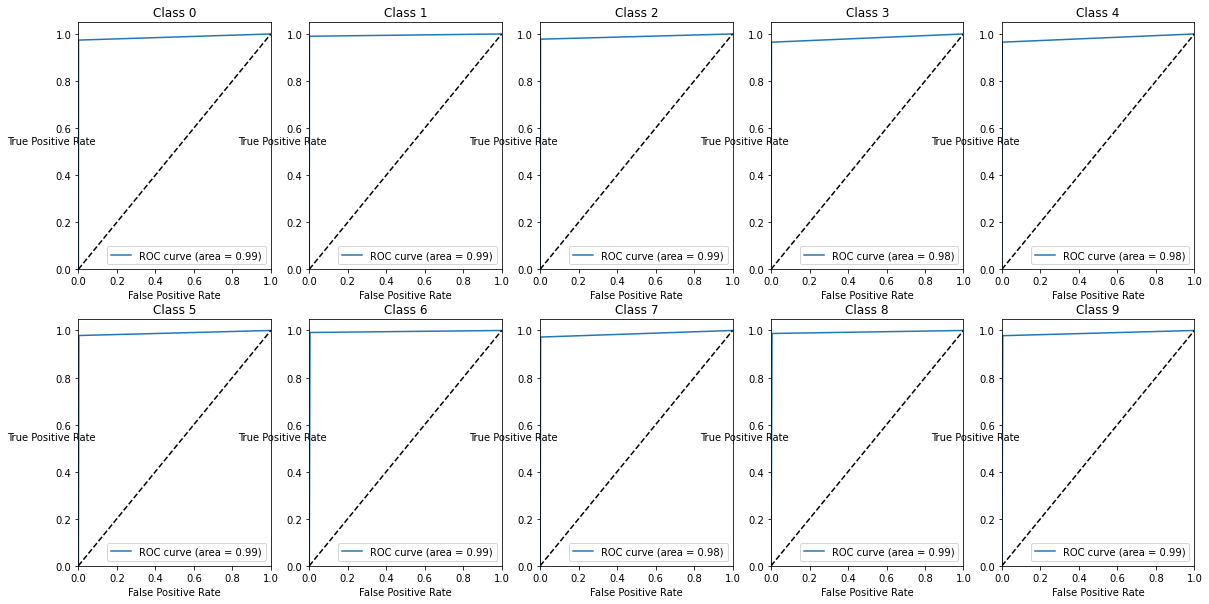

MNIST Training...:  60%|██████    | 9/15 [02:14<01:29, 14.92s/it]

roc_auc_score:  0.9877480959534228
[9] Test Loss: 0.0875, Accuracy: 97.79%
Train Epoch: 10 
Pred: tensor([9, 8, 3,  ..., 7, 6, 8])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 971    0    5    0    1    2    3    2    8    1]
 [   1 1126    2    0    0    0    2    1    2    3]
 [   1    3 1008    1    3    0    0    7    1    0]
 [   1    1    4  980    0    4    1    1    4    0]
 [   0    0    1    1  960    0    2    0    3   12]
 [   1    2    0   15    1  881    6    0   25    5]
 [   3    1    0    0    4    2  944    0    4    0]
 [   1    1    8    5    2    1    0 1011    5    0]
 [   0    1    3    0    0    1    0    1  915    0]
 [   1    0    1    8   11    1    0    5    7  988]]
recall all: [0.97784491 0.99032542 0.984375   0.98393574 0.98059244 0.94123932
 0.98538622 0.97775629 0.99348534 0.9667319 ]
recall avg: 0.9784
precision all: [0.99081633 0.99207048 0.97674419 0.97029703 0.97759674 0.98766816
 0.98538622 0.98346304 0.93942505 0.97918731]
precision avg: 

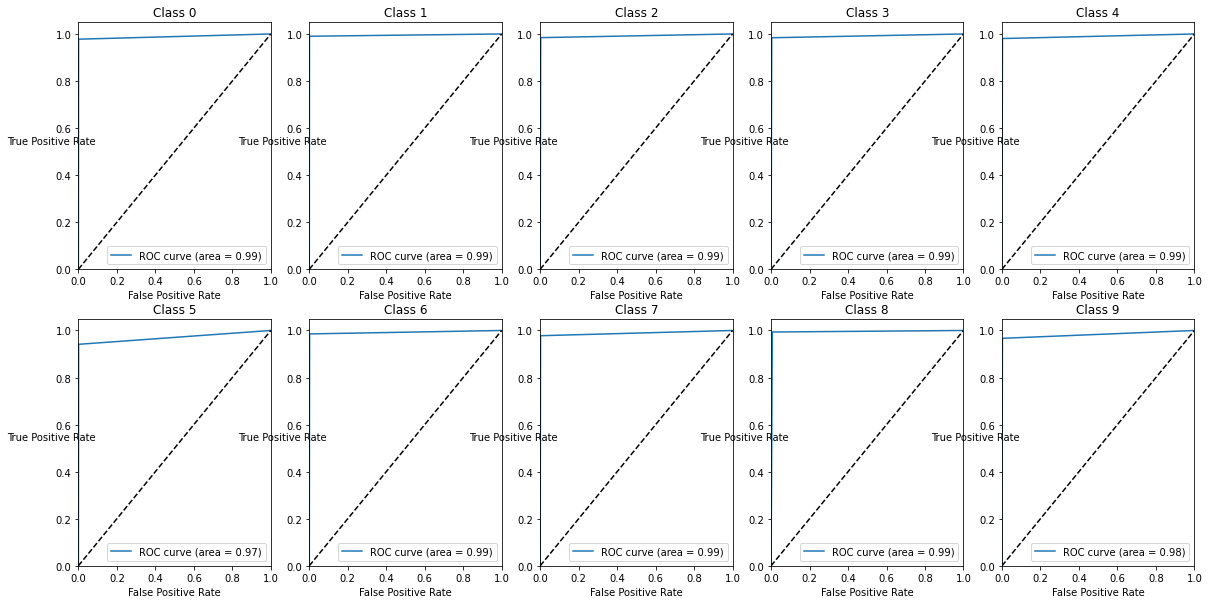

MNIST Training...:  67%|██████▋   | 10/15 [02:29<01:14, 14.97s/it]

roc_auc_score:  0.9878858979366221
[10] Test Loss: 0.0935, Accuracy: 97.84%
Train Epoch: 11 
Pred: tensor([1, 2, 0,  ..., 9, 5, 3])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 971    0    0    0    0    2    2    1    1    1]
 [   1 1126    2    0    0    0    1    3    0    2]
 [   1    5 1012    5    5    0    0   10    3    0]
 [   1    0    4  994    0   19    1    2    7    5]
 [   0    0    1    0  949    0    2    0    1    8]
 [   0    1    0    4    1  860    3    0    7    8]
 [   2    2    0    0    8    6  947    0    0    1]
 [   1    0    5    4    1    1    0 1009    4   17]
 [   2    1    7    2    0    3    2    3  950    6]
 [   1    0    1    1   18    1    0    0    1  961]]
recall all: [0.99284254 0.99207048 0.97214217 0.96224589 0.98751301 0.97285068
 0.98033126 0.96833013 0.97336066 0.97662602]
recall avg: 0.9779
precision all: [0.99081633 0.99207048 0.98062016 0.98415842 0.96639511 0.96412556
 0.98851775 0.98151751 0.97535934 0.95242815]
precision avg:

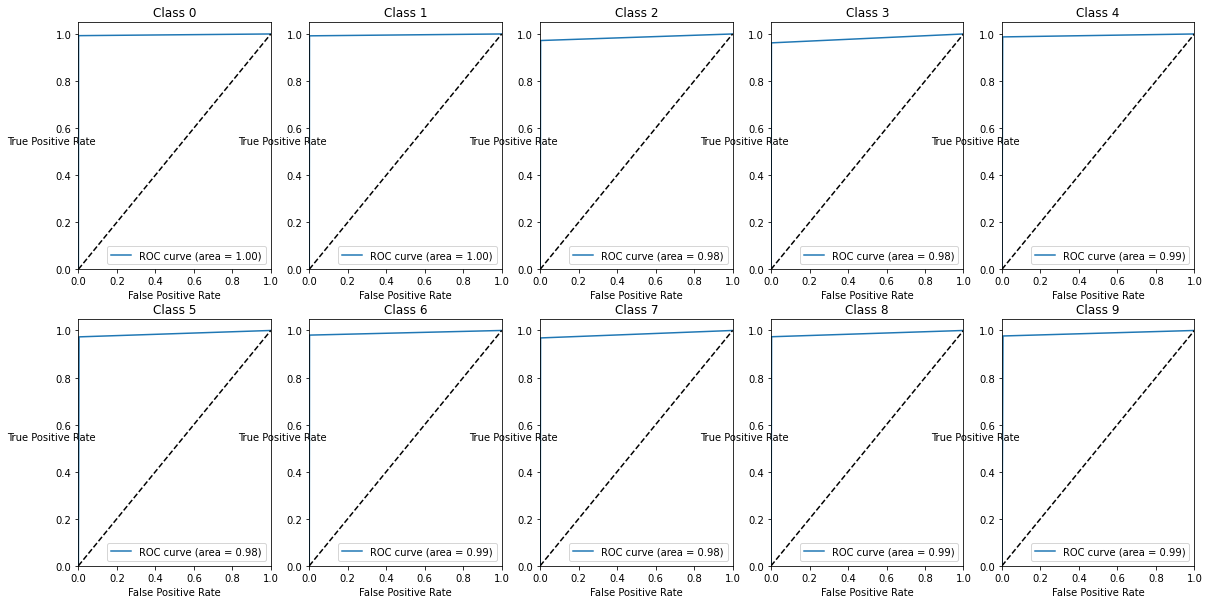

MNIST Training...:  73%|███████▎  | 11/15 [02:44<00:59, 14.97s/it]

roc_auc_score:  0.9876900048857677
[11] Test Loss: 0.0966, Accuracy: 97.79%
Train Epoch: 12 
Pred: tensor([2, 3, 7,  ..., 1, 7, 4])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 972    0    5    0    0    2    3    1    1    1]
 [   1 1129    2    1    1    1    1    2    0    3]
 [   1    2 1014    7    4    0    0    7    5    0]
 [   0    0    0  981    0    9    1    0    6    3]
 [   0    0    1    1  965    1    5    0    3    8]
 [   0    1    0    4    0  865    2    0    3    2]
 [   3    2    2    0    5    3  942    0    0    0]
 [   1    0    5    7    1    1    0 1012    5    2]
 [   0    1    2    2    0    5    2    2  948    1]
 [   2    0    1    7    6    5    2    4    3  989]]
recall all: [0.98680203 0.98948291 0.975      0.981      0.98069106 0.98631699
 0.98432602 0.9787234  0.98442368 0.97055937]
recall avg: 0.9817
precision all: [0.99183673 0.99471366 0.98255814 0.97128713 0.98268839 0.96973094
 0.98329854 0.9844358  0.97330595 0.98017839]
precision avg:

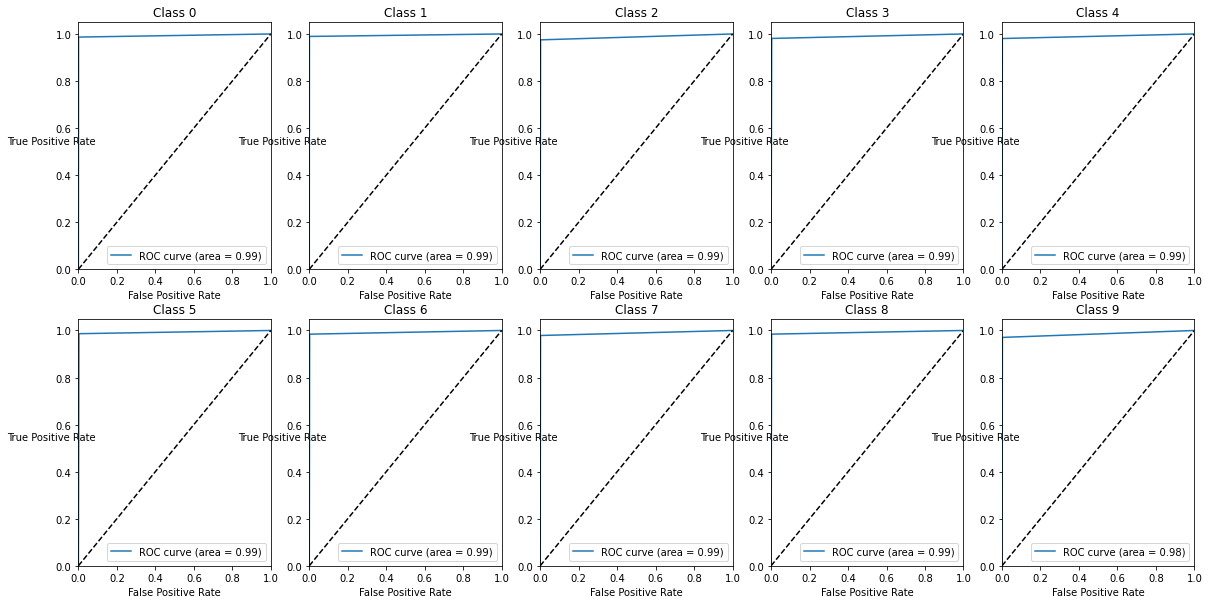

MNIST Training...:  80%|████████  | 12/15 [02:59<00:45, 15.04s/it]

roc_auc_score:  0.9898513351059451
[12] Test Loss: 0.0792, Accuracy: 98.17%
Train Epoch: 13 
Pred: tensor([6, 7, 5,  ..., 3, 0, 1])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 973    0    5    0    2    1    5    2    3    2]
 [   1 1118    3    0    0    0    1    0    0    0]
 [   1    4 1001    5    2    0    0    8    2    0]
 [   0    1    3  967    0    2    1    2    5    0]
 [   0    0    3    0  963    0    6    0    6    3]
 [   1    0    0   29    0  880    6    0    9    5]
 [   1    2    3    0    4    2  934    0    0    0]
 [   1    1    6    3    1    0    0 1009    2    1]
 [   1    8    7    1    0    3    4    2  943    0]
 [   1    1    1    5   10    4    1    5    4  998]]
recall all: [0.97985901 0.99554764 0.97849462 0.98572885 0.98165138 0.94623656
 0.98731501 0.98535156 0.97316821 0.96893204]
recall avg: 0.9786
precision all: [0.99285714 0.98502203 0.96996124 0.95742574 0.98065173 0.98654709
 0.97494781 0.98151751 0.96817248 0.98909812]
precision avg:

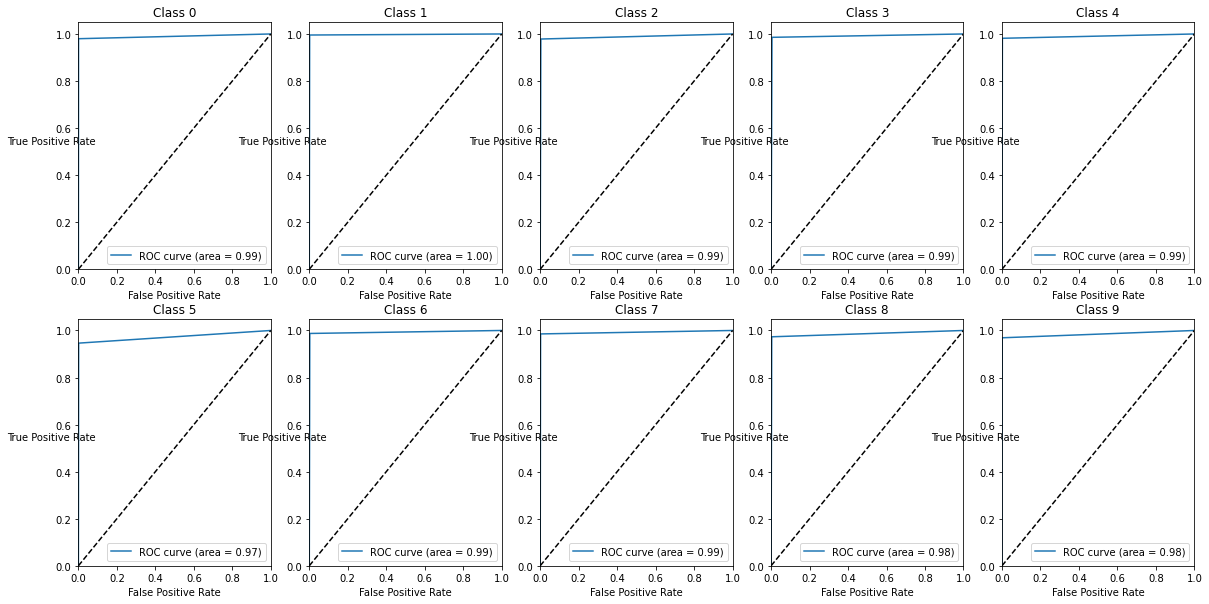

MNIST Training...:  87%|████████▋ | 13/15 [03:14<00:30, 15.09s/it]

roc_auc_score:  0.9879257757344975
[13] Test Loss: 0.0985, Accuracy: 97.86%
Train Epoch: 14 
Pred: tensor([7, 5, 5,  ..., 8, 4, 0])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 972    0    2    0    2    1    2    2    2    3]
 [   1 1131    3    0    1    0    2    7    0    3]
 [   1    1 1008    5    2    0    0    9    1    0]
 [   2    1    4  980    0    4    1    1    4    2]
 [   0    0    1    1  962    1    2    0    4    8]
 [   0    0    0    8    0  875    5    0    3    3]
 [   2    1    1    0    5    4  945    0    0    0]
 [   1    0    4    4    2    2    0 1000    2    1]
 [   1    1    8    6    0    3    1    2  954    1]
 [   0    0    1    6    8    2    0    7    4  988]]
recall all: [0.98580122 0.98519164 0.98149951 0.98098098 0.98263534 0.9787472
 0.98643006 0.98425197 0.97645855 0.97244094]
recall avg: 0.9815
precision all: [0.99183673 0.99647577 0.97674419 0.97029703 0.9796334  0.9809417
 0.98643006 0.97276265 0.97946612 0.97918731]
precision avg: 0

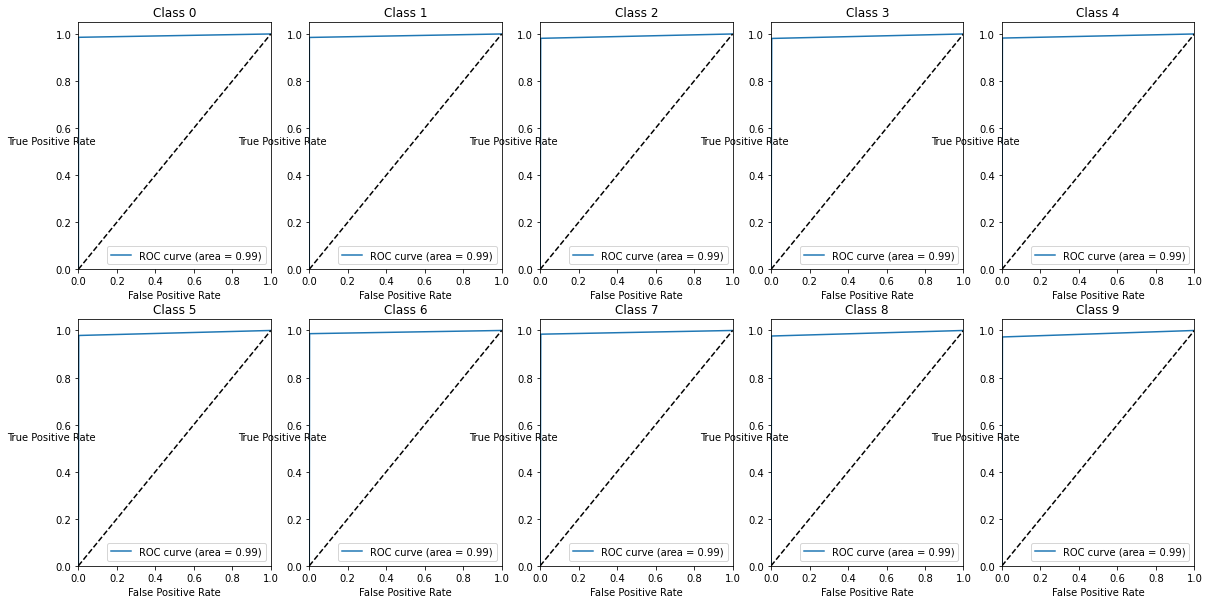

MNIST Training...:  93%|█████████▎| 14/15 [03:29<00:15, 15.05s/it]

roc_auc_score:  0.9896948998177647
[14] Test Loss: 0.0880, Accuracy: 98.15%
Train Epoch: 15 
Pred: tensor([7, 2, 0,  ..., 7, 7, 5])
pred shape: torch.Size([10000])
Confusion Matrix:  [[ 965    0    1    0    1    1    7    2    2    0]
 [   1 1123    1    0    0    1    1    2    0    1]
 [   7    2 1013    1    3    0    0    8    2    0]
 [   1    1    2 1000    0   21    1    2    4    5]
 [   0    0    3    0  966    0    3    1    2   10]
 [   0    0    0    2    0  862    6    0    2    1]
 [   1    2    1    0    6    1  936    0    0    1]
 [   0    1    3    3    1    0    0 1007    1    1]
 [   4    6    7    1    2    3    4    1  956    2]
 [   1    0    1    3    3    3    0    5    5  988]]
recall all: [0.98569969 0.99380531 0.97779923 0.96432015 0.98071066 0.98739977
 0.98734177 0.99016716 0.96957404 0.97918731]
recall avg: 0.9816
precision all: [0.98469388 0.98942731 0.98158915 0.99009901 0.98370672 0.96636771
 0.97703549 0.97957198 0.98151951 0.97918731]
precision avg:

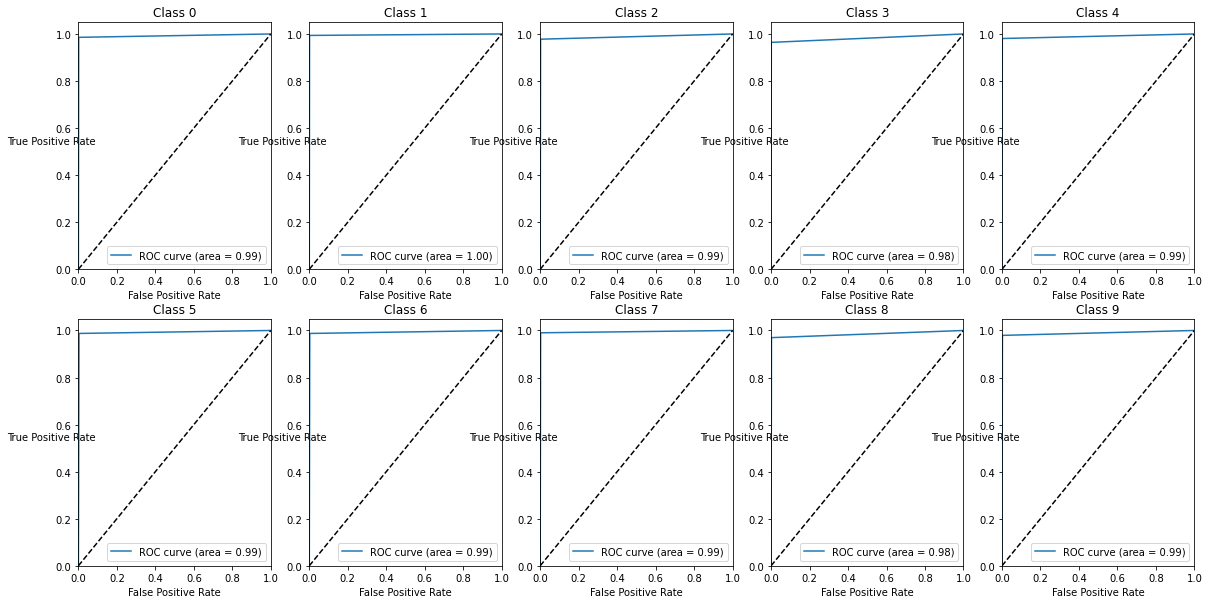

MNIST Training...: 100%|██████████| 15/15 [03:44<00:00, 14.98s/it]

roc_auc_score:  0.9897795831916805
[15] Test Loss: 0.0917, Accuracy: 98.16%


In [13]:
# tqdm 사용시 for문의 진행정도 표현가능 desc: describe로 왼쪽에 뜰 텍스트 정함.
for epoch in tqdm(range(1, 15 + 1), desc="MNIST Training...", mininterval=0.01):
    train(model, train_dataset, optimizer)
    test_loss, test_accuracy = evaluate(model, test_dataset)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    time.sleep(0.1)

In [14]:
writer.close()

In [15]:
# 텐서보드 띄우기
%load_ext tensorboard
%tensorboard --logdir runs --port=6006

Reusing TensorBoard on port 6006 (pid 29514), started 1 day, 14:24:55 ago. (Use '!kill 29514' to kill it.)